# Covid-19 Analysis - Unemployment in the USA - by Insurance Claims, Job postings

In this notebook, we analyze unemployment in the USA by initial and continued Unemployment Insurance claims(PART 1), and  Average job postings(PART 2).

We compare all the states, regions, and populations to the criteria mentioned above.

### Data source 1 : [Unemployment Insurance Weekly Claims Data](https://oui.doleta.gov/unemploy/claims.asp)

This data is used in the current economic analysis of unemployment trends in the USA, and each of its states. 
Initial claims measure unemployment and continued weeks claimed to measure the number of people claiming unemployment benefits.

### Data source 2: [Average level of job postings](https://github.com/OpportunityInsights/EconomicTracker)

This data is Job postings data from Burning Glass Technologies.
It provides average level job postings by different industries like Manufacturing, financial activities, professional and business services, education, and health services, leisure, and hospitality.

These numbers are in comparison with data from January 4-31,2020.
So we can get a bit of an idea about before and during the effects of the pandemic.

### Data source 3 : [COVID 19 cases  - nytimes](https://github.com/nytimes/covid-19-data/blob/master/live/us-states.csv)

This data will be integrated with the first data source to provide COVID analysis. Particularly 'cases' will be taken into consideration.
Cases are the total number of cases of Covid-19, including both confirmed and probable.


**Since there are too many states to focus on, I will refer to Hawaii throughout this analysis to showcase how COVID CASES, industry job postings, and unemployment insurance claims could be related.**

Also, This alanysis should be considered with a grain of salt as I am not a pandemic expert.

The code for this analysis can be found in [this notebook](https://github.com/nagarajbhat/nagarajbhat.github.io/blob/master/covid19_unemployment_analysis/analysis.ipynb) , and can be viewed with nbviewer [here](https://nbviewer.jupyter.org/urls/nagarajbhat.github.io/covid19_unemployment_analysis/analysis.ipynb) .

In [201]:
#dependencies
import pandas as pd
import plotly.express as px
import plotly.offline as py
import plotly.graph_objects as go
from flask import Markup
import plotly
from plotly.offline import iplot
from plotly.subplots import make_subplots

import matplotlib.pyplot as plt
import seaborn as sns

plotly.offline.init_notebook_mode(connected=True)


# Part 1: Unemployment Insurance claims - state aggregate


In [202]:
#data source - United states department of labour https://oui.doleta.gov/unemploy/claims.asp
df = pd.read_csv('./data/unemp_claims.csv',sep="\t")
# group states together and taking mean values

#df_statewise
df.head()
df['Initial Claims'] = df['Initial Claims'].str.replace(',', '').astype(float)
df['Continued Claims'] = df['Continued Claims'].str.replace(',', '').astype(float)
df['Covered Employment'] = df['Covered Employment'].str.replace(',', '').astype(float)

df_statewise = df.groupby(['State']).mean().reset_index()


df_state  = pd.read_csv('./data/EconomicTracker/data/GeoIDs - State.csv')
df_covid = pd.read_csv('./data/covid_us_states.csv')
df_covid = df_covid.filter(['fips','cases'])

#merge covid and state
df_state = df_state.merge(df_covid,left_on='statefips',right_on='fips')

#merge population
df_statewise = df_statewise.merge(df_state,left_on='State',right_on='statename')
df_statewise['population'] = df_statewise['state_pop2019']
df_statewise = df_statewise.drop(['state_pop2019'],axis=1)
#df_statewise

## Merrge region code -
df_region = pd.read_csv('./data/region_code.csv').filter(['State Code','Region'])
df_statewise = df_statewise.merge(df_region,left_on='stateabbrev',right_on='State Code')

# group states together
df_statewise = df_statewise.groupby(['State','stateabbrev','Region']).mean().reset_index()
#merge covid
#df_statewise
#df_statewise

## Initial claims vs continued claims vs Covid-19 cases vs  population - by region
**DISCLAIMER: Initial and continued claims, and COVID-19 Cases have been scaled up *10 in the pie chart below because they were too small in comparison with the population.**

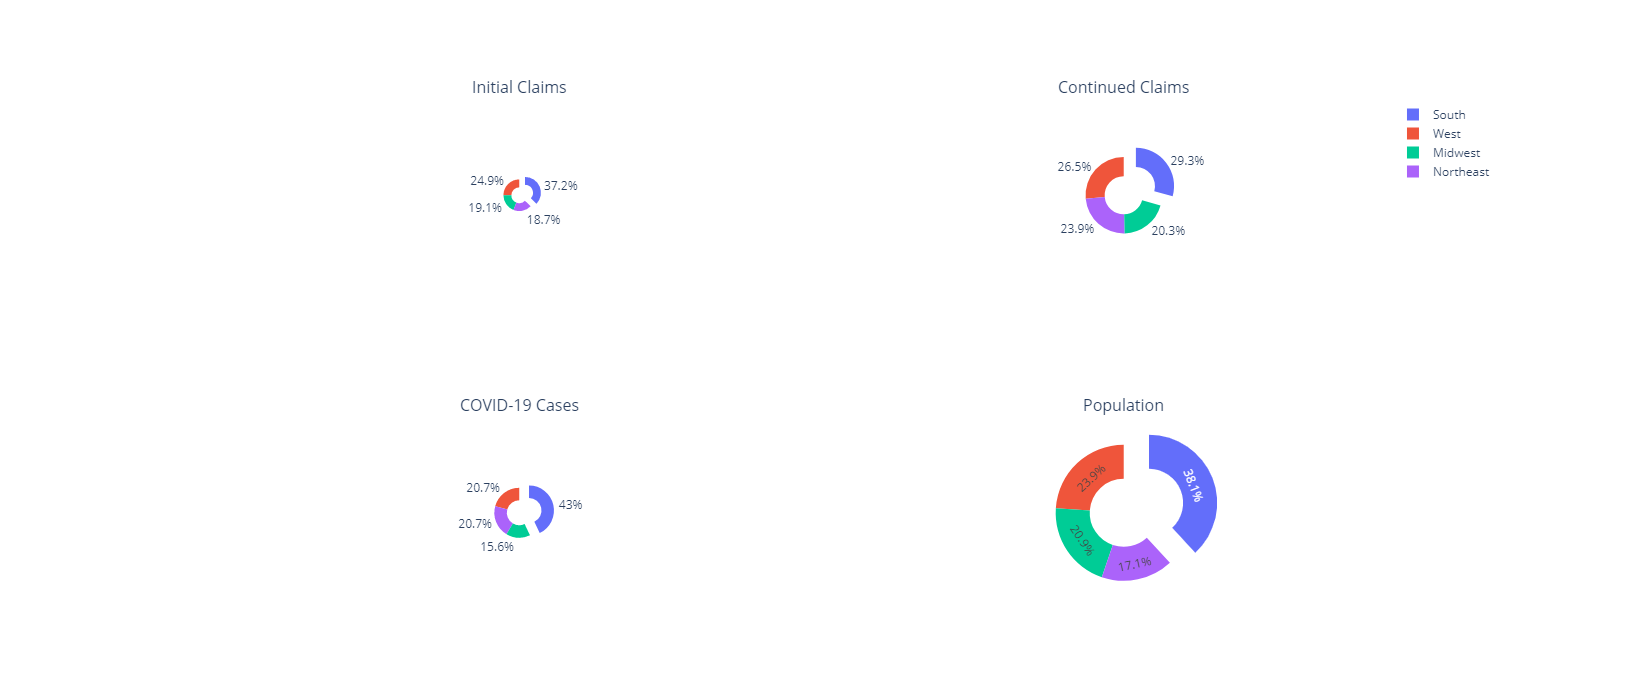

In [203]:
data = df_statewise
#data = data[data['statename']=='California']

fig=make_subplots(rows=2,cols=2,
                 subplot_titles = ['Initial Claims','Continued Claims','COVID-19 Cases','Population'],
                 specs=[[{'type':'domain'}, {'type':'domain'}],[{'type':'domain'},{'type':'domain'}]])



fig.add_trace(go.Pie(labels=data['Region'],
                    values=data['Initial Claims']*10,name="Initial Cliams",scalegroup='one',pull=[0.4, 0, 0, 0],
                    hole=.5),1,1)
fig.add_trace(go.Pie(labels=data['Region'],
                    values=data['Continued Claims']*10,name="Conitued Claims",scalegroup='one',pull=[0.4, 0, 0, 0],
                    hole=.5),1,2)
fig.add_trace(go.Pie(labels=data['Region'],
                    values=data['cases']*10,name="COVID-19 Cases",scalegroup='one',pull=[0.4, 0, 0, 0],
                    hole=.5),2,1)
fig.add_trace(go.Pie(labels=data['Region'],
                    values=data['population'],name="Population",scalegroup='one',pull=[0.4, 0, 0, 0],
                    hole=.5),2,2)


fig.update_layout(height=700)
fig.show()

#fig.print_grid()

### Correlation between them
We can see that all 4 criteria have a high correlation between them.

Although it is important to note that correlation does not automatically mean causation.

- Initial and continued claims have the highest correlation (0.96)
- Whereas Continued claims and cases have lesser correlation comparatively (although still a high value of 0.85)

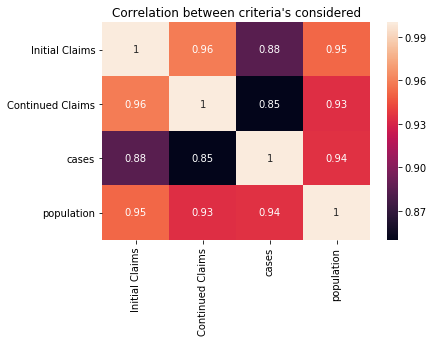

In [204]:
df.corr
#px.data.medals_wide(indexed=True)
data = df_statewise.filter(['Initial Claims','Continued Claims','cases','population'])
ax = sns.heatmap(data.corr(), annot=True) #notation: "annot" not "annote"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title("Correlation between criteria's considered")
plt.show()


## Initial Claims

### Population and claims correlations 

In the first graph, we plot the correlation between population and Initial claims from each state. 
- We see there is some sort of linear correlation, although we see there are a lot of exceptions.
- For example, Georgia and North Carolina have comparable populations of just above 10 million, yet the number of initial claims for Georgia is more than twice that of North Carolina.
- Also Texas, Florida, New York, and Georgia have a comparable number of Initial Claims despite stark differences in their population(range close to 20 M).
- California has both the highest population and highest Initial Claims.

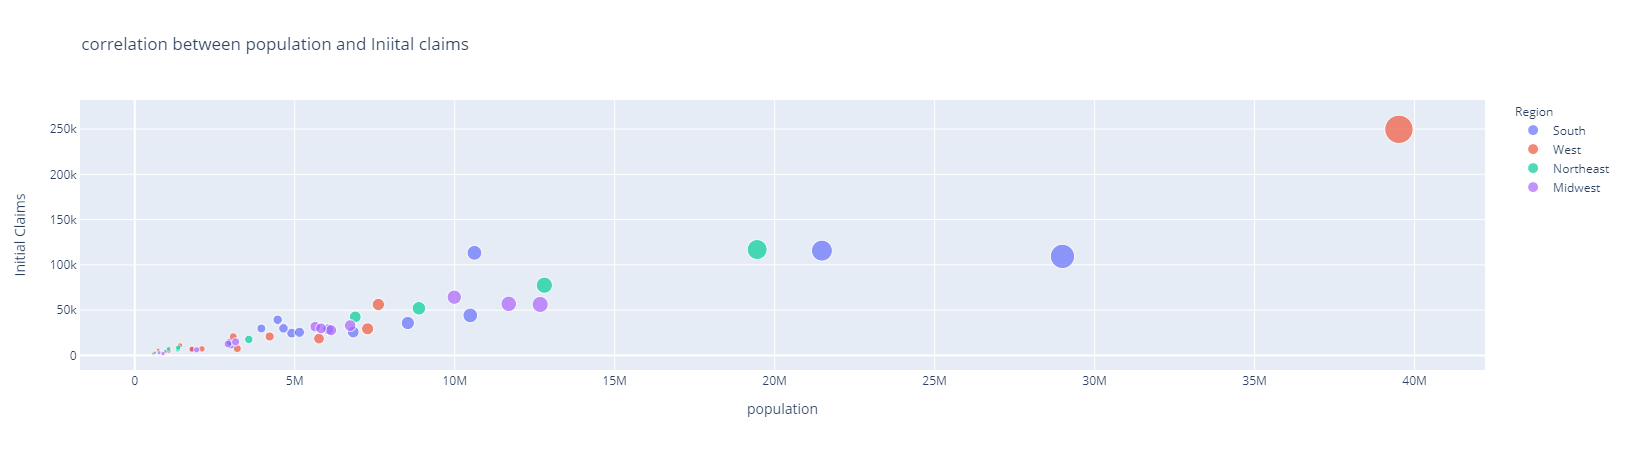

In [205]:
px.scatter(df_statewise,y="Initial Claims",x="population",color="Region",hover_data=["State"],size="population",title="correlation between population and Iniital claims")


In the graph below we can see that -
- States with high initial claims - California, Florida, Georgia, Texas, New York 
- Georgia has the same amount of initial claims as compared to Florida despite having a much lower population and one-third the amount of COVID-19 cases

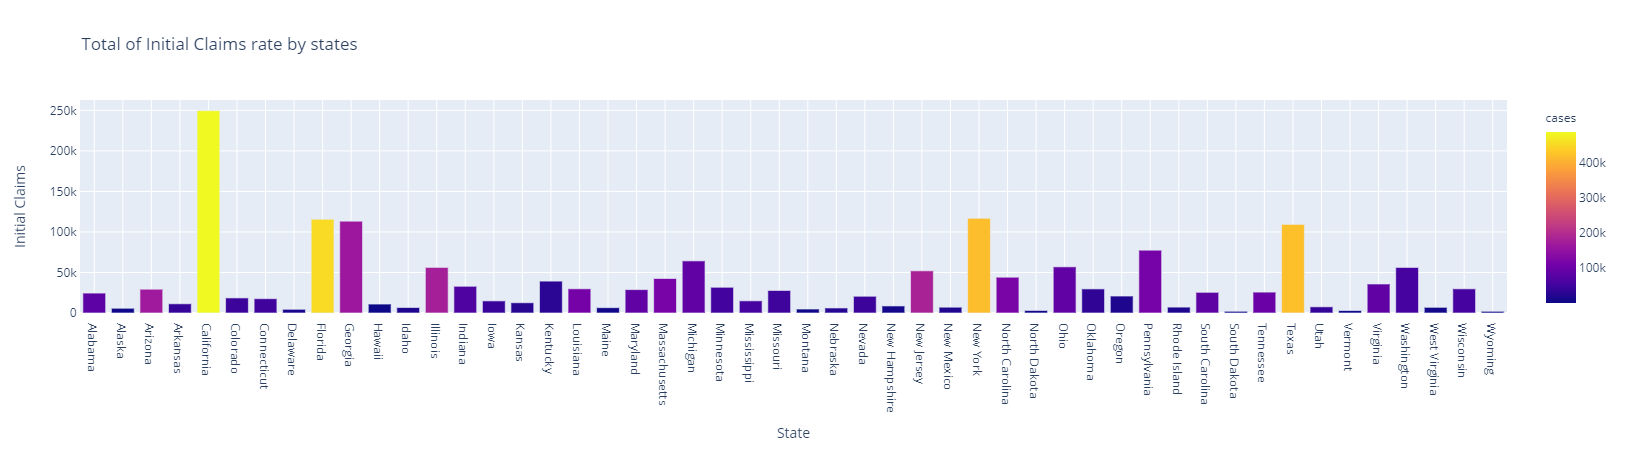

In [206]:
fig = px.bar(df_statewise,x='State',y='Initial Claims',title ="Total of Initial Claims rate by states",color='cases')
fig.show()

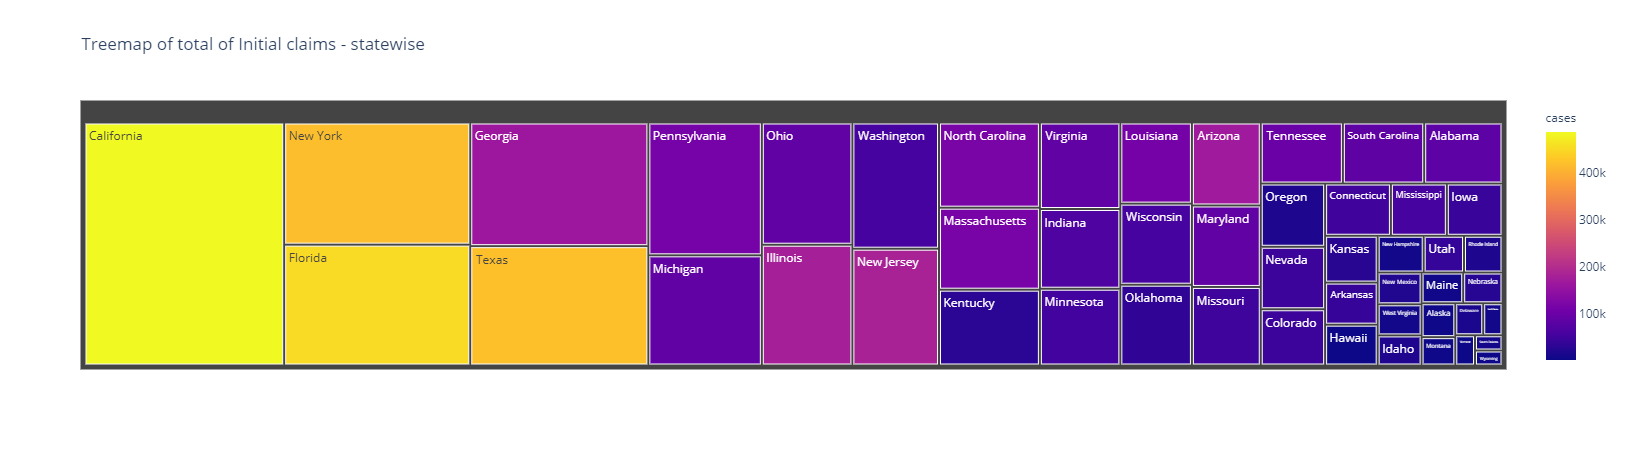

In [207]:
#color_continuous_scale=px.colors.sequential.Viridis
fig = px.treemap(df_statewise, path=['State'], values='Initial Claims',color='cases',title="Treemap of total of Initial claims - statewise")
fig.show()

## Continued Claims

- At a glance, we can see that, compared to Initial claims where New York and Florida were at similar values, for continued claims New York is almost twice the value of Florida.
- Alo Florida despite having a much larger population, has lesser continued claims when compared to much lesser populated states such as Pennsylvania, Michigan, and Illinois.

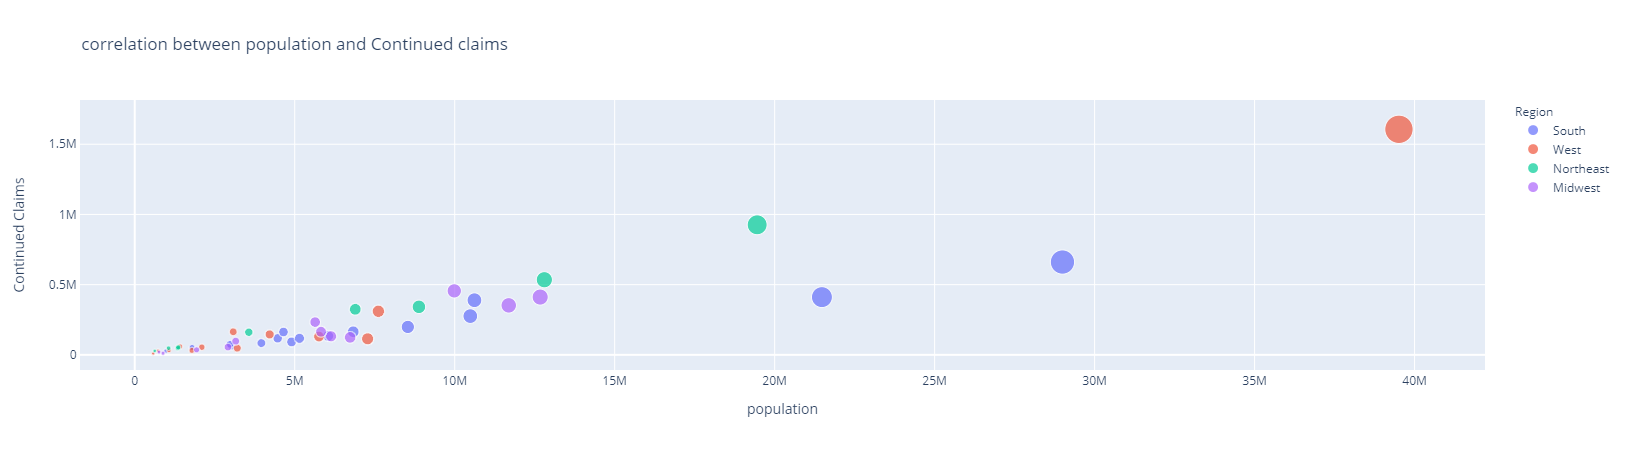

In [208]:
px.scatter(df_statewise,y="Continued Claims",x="population",color="Region",hover_data=["State"],size="population",title="correlation between population and Continued claims")

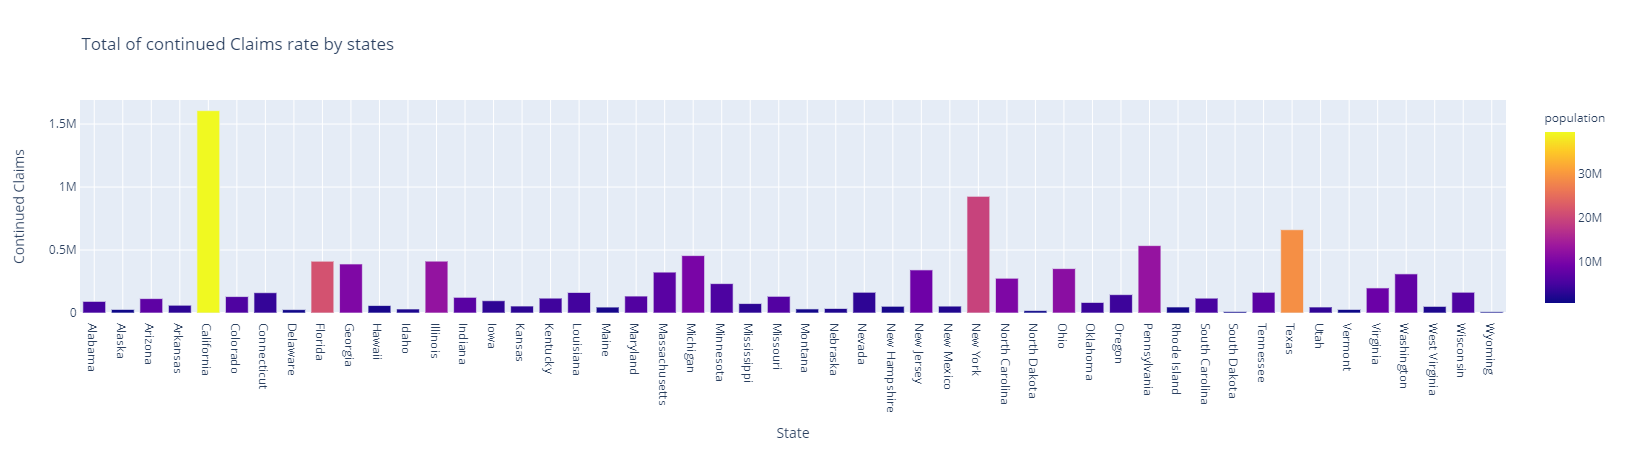

In [209]:
px.bar(df_statewise,x='State',y='Continued Claims',title ="Total of continued Claims rate by states",color='population')

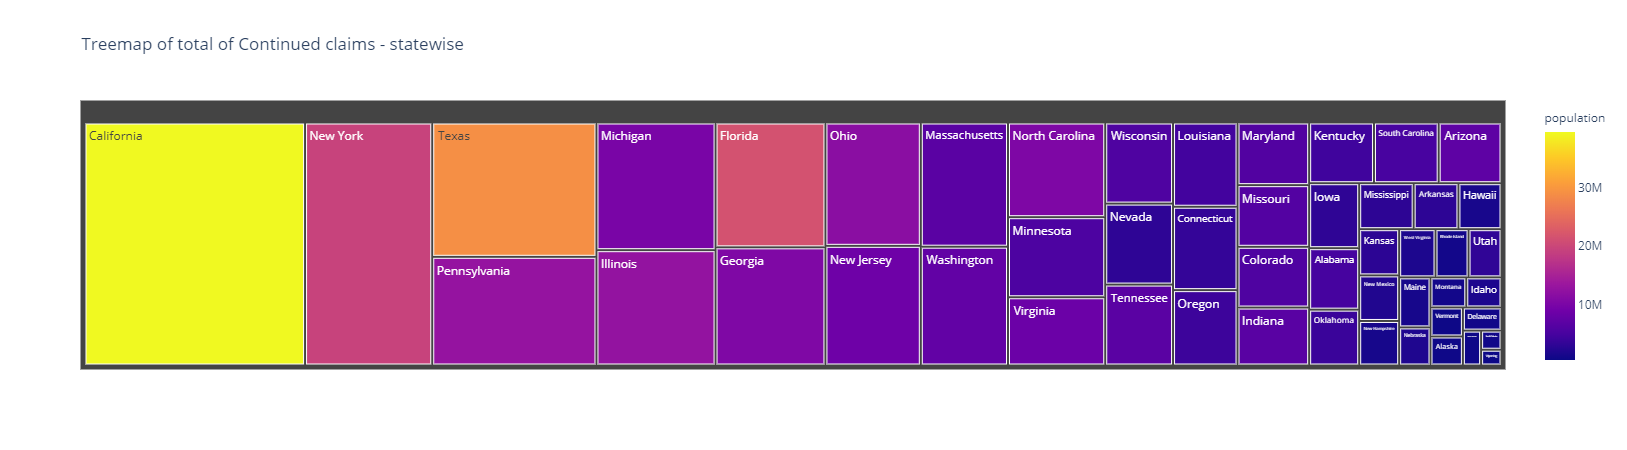

In [210]:
fig = px.treemap(df_statewise, path=['State'], values='Continued Claims',color='population',title="Treemap of total of Continued claims - statewise")
fig.show()

## Comparing Continued Claims vs COVID-19 Cases
Continued claims and COVID-19 cases have a correlation of 0.85. 

For a better analysis, it would be good to have states with a comparable population in the same group and see how COVID has affected the continued claims in those states.
### 6.5 to 7 million (Comparable population)

For example, consider Massachusetts, Tennesee, and Indiana, all three have a population close to 7 Million.
But the continued claims vary from 124K in Indiana, to 164K in Tennessee to 324k in Massachusetts.

Things to note - 
- For states with a higher number of cases, the continued claims (of unemployment insurance) are also very high. This is the expected behavior.
- Although Massachusetts has almost double the number of continued claims when compared with Tennesee for COVID-19 cases increase of just under 20%.

In [211]:
df_statewise_7m = df_statewise[(df_statewise['population']>6500000)&(df_statewise['population']<7000000)]
#df_statewise_7m

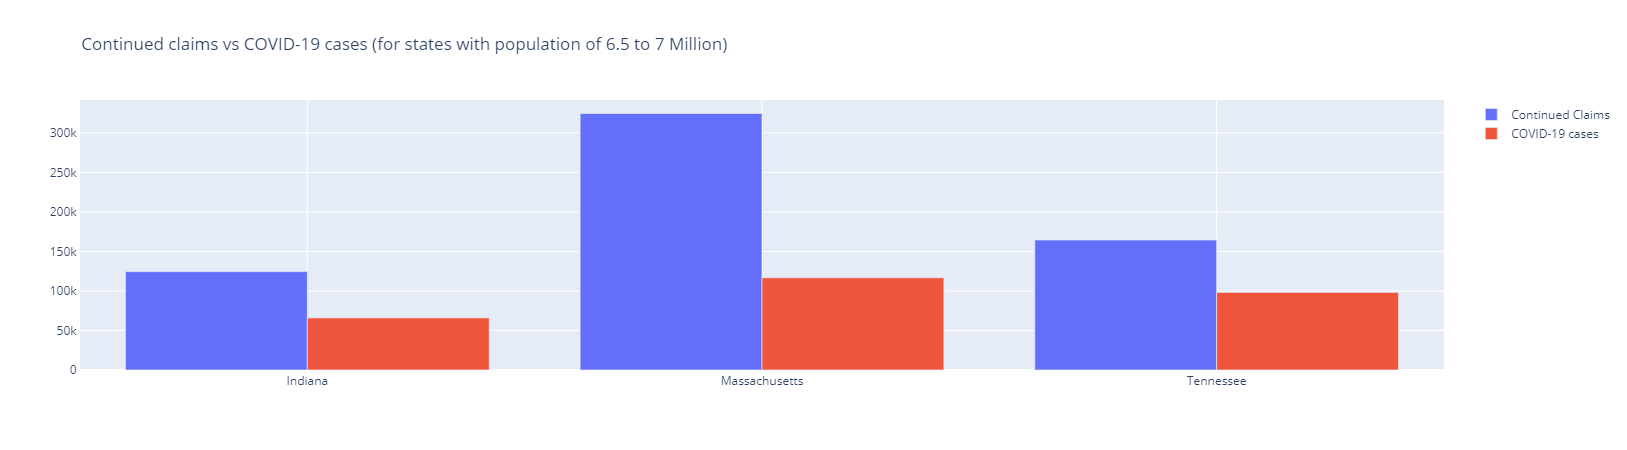

In [212]:
df = df_statewise_7m
fig = go.Figure(data=[
    go.Bar(name='Continued Claims', x=df['State'], y=df['Continued Claims']),
    go.Bar(name='COVID-19 cases', x=df['State'], y=df['cases'])
])
# Change the bar mode
fig.update_layout(barmode='group',title="Continued claims vs COVID-19 cases (for states with population of 6.5 to 7 Million)")
fig.show()

### All States

Now let us plot this graph for all states. This might give us some anomalies that break away from this expected behavior.

In the plot below we can observe, there are a few states in which the number of continued claims is less than the number of COVID-19 cases. For example - 
- Arizona - continued claims of 114k, and cases are 168k. And Florida claims are 411k, and cases are 451k. This breaks away from the pattern of claims being higher than COVID-19 cases.

    This can mean either 2 things, 
    - one - COVID-19 hasn't affected the unemployment in these states that much.
    - or two - fewer people have applied for unemployment insurance claims than they should have. 

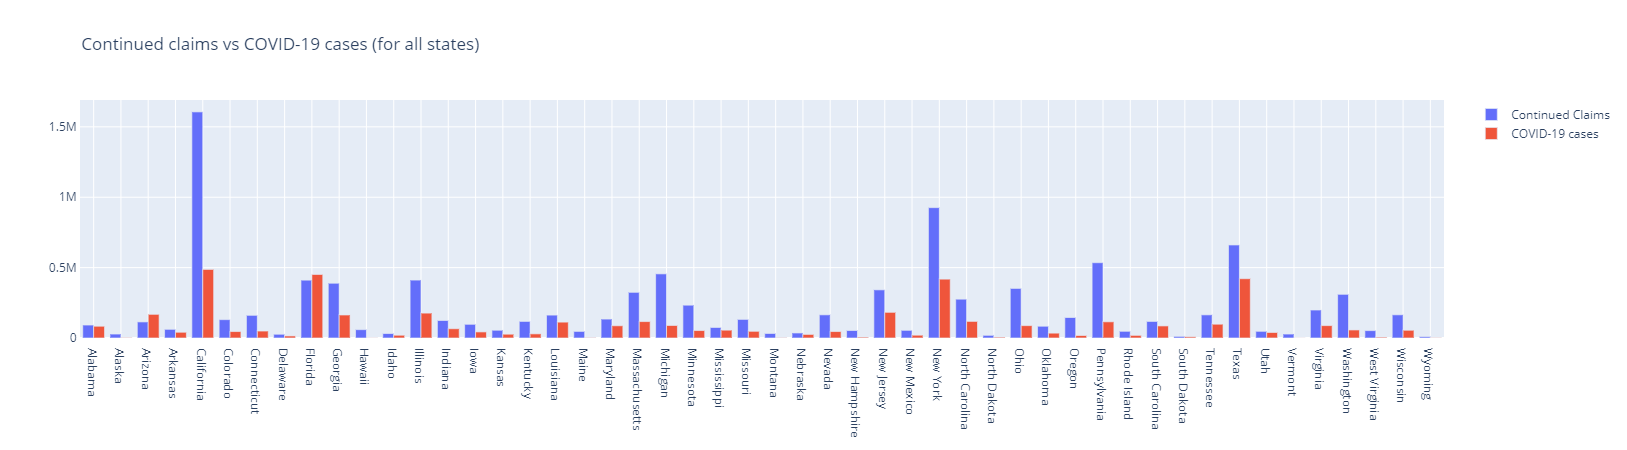

In [213]:
df = df_statewise
fig = go.Figure(data=[
    go.Bar(name='Continued Claims', x=df['State'], y=df['Continued Claims']),
    go.Bar(name='COVID-19 cases', x=df['State'], y=df['cases'])
])
# Change the bar mode
fig.update_layout(barmode='group',title="Continued claims vs COVID-19 cases (for all states)")
fig.show()

### Continued Claims per COVID-19 Cases by States
To find more patterns, I divided Continued Claims by COvid-19 cases and plotted a scatter plot against States, colored by region and size is proportional to its population.

Things to note -
- For some reason, the value for Hawaii is too high at 32.19. The main reason can be that Hawaii has a very low number of COIVD cases.
    
    one more reason could be that the Hawaii economy depends heavily on tourism, and the tourism industry has taken a hit during COVID-19.More on this in part -2.
- The population doesn't seem to have much of an effect on this, although all high values are generated by lower populated states.
- Some high values for Claims per case - Hawaii, Maine, West Virginia, Alaska, Montana, Oregon, New Hampshire.

Pitfalls - 
- High Claims per case doesn't necessarily mean there is high unemployment. It could just mean there are a very low number of COVID cases in the state

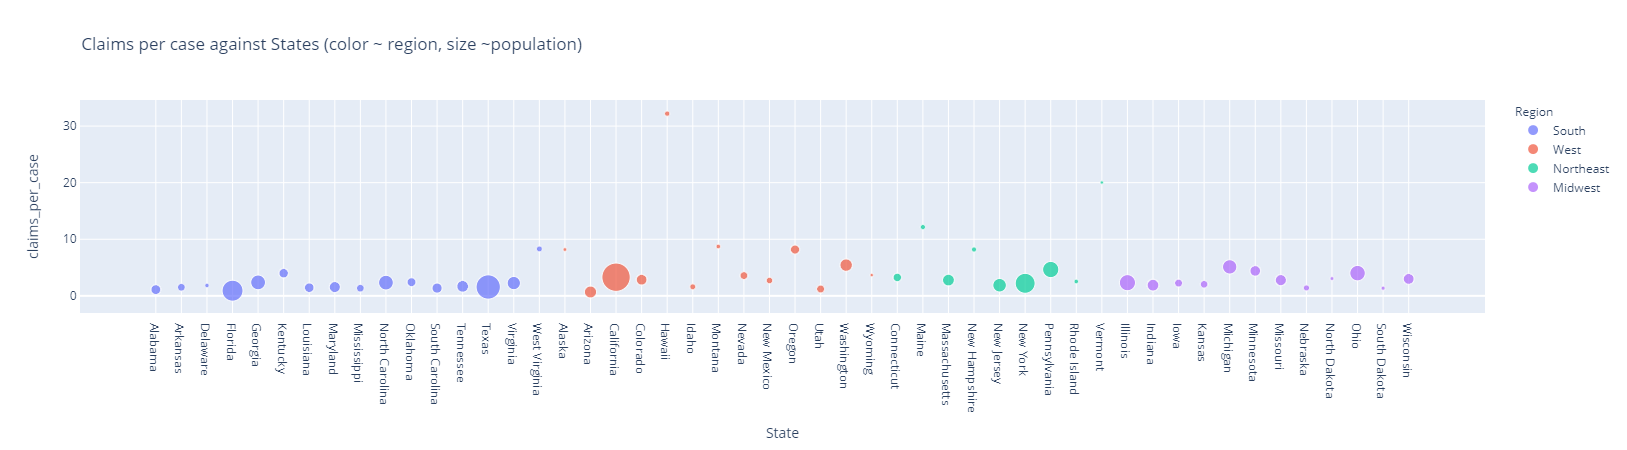

In [214]:
data = df_statewise
data['claims_per_case'] = data['Continued Claims']/data['cases']
px.scatter(data,x='State',y='claims_per_case',color='Region',size='population',title="Claims per case against States (color ~ region, size ~population)")



# Part 2:Average Job postings
What do the values mean?

The values are average job postings relative to Jan 4-32,2020.So If the scores are in positive there are more job postings now when compared to Jan, 
and if the scores are in negative there are fewer job postings comparatively.

In [215]:
#data prep
df_state  = pd.read_csv('./data/EconomicTracker/data/GeoIDs - State.csv')
df_burning  = pd.read_csv('./data/EconomicTracker/data/Burning Glass - State - Weekly.csv')

df_burnings = df_burning.iloc[:,0:10]
df_burnings['day']=df_burnings['day_endofweek']
df_burnings['date'] = pd.to_datetime(df_burnings[['year', 'month', 'day']])
df_burnings = df_burnings.drop(['year','month','day_endofweek','day'],axis=1)
#df_burnings.columns

#rename
df_burnings.columns = ['statefips', 'all industries', 'manufacturing', 'financial activities',
       'professional and business services', 'education and health services', 'leisure and hospitality', 'date']
df_burnings
df_burnings = df_burnings.merge(df_state,on='statefips')

## Merrge region code -
df_region = pd.read_csv('./data/region_code.csv').filter(['State Code','Region'])
df_burnings = df_burnings.merge(df_region,left_on='stateabbrev',right_on='State Code')
df_burnings

##statewise
df_burnings_state = df_burnings.groupby(['statename','stateabbrev','Region']).mean().reset_index()
df_burnings_state['population'] = df_burnings_state['state_pop2019']
df_burnings_state = df_burnings_state.drop(['state_pop2019'],axis=1)
df_burnings_state.head()



#datewise
df_burnings_date = df_burnings.groupby(['date']).mean().reset_index()
#df_burnings_state['population'] = df_burnings_state['state_pop2019']
df_burnings_date = df_burnings_date.drop(['state_pop2019','statefips'],axis=1)

#date_state_wise
df_burnings_date_state = df_burnings.groupby(['date','statename','state_pop2019','Region']).mean().reset_index()
df_burnings_date_state['population'] = df_burnings_date_state['state_pop2019']
df_burnings_date_state = df_burnings_date_state.drop(['state_pop2019'],axis=1)
#df_burnings_date_state.head()

#df_burnings_state.head()


## Correlation between different industries
If we plot a correlation matrix between different industries, we can see which industry has the most influence on "all industries".
- We see that Education and health services had a high correlation with all industries (0.72).
- Whereas, professional and business services had the least correlation with all industries(0.37).

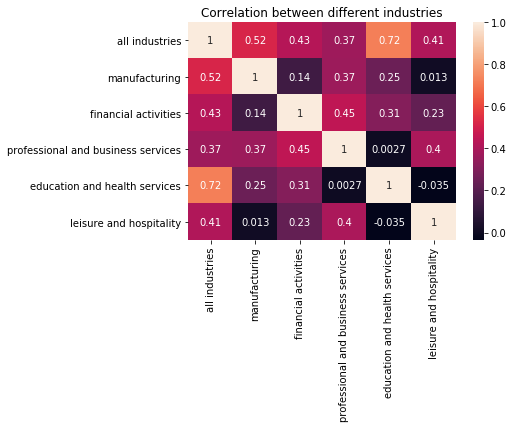

In [216]:
data = df_burnings_state.filter(['all industries','manufacturing','financial activities','professional and business services','education and health services','leisure and hospitality'])
ax = sns.heatmap(data.corr(), annot=True) #notation: "annot" not "annote"
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.set_title('Correlation between different industries')
plt.show()

## Timeline of Average job postings - Different industry comparison (relative to January 4-31 2020)

One interesting factor to note here is the effect of lockdown, according to a report, Twenty-six U.S. states see a rise in coronavirus cases since easing up on lockdown restrictions. - [source](https://www.thinkglobalhealth.org/article/updated-timeline-coronavirus)

We can also see a surge in job postings(especially leisure and hospitality) during June, July after a drop during April, May. So lockdown has an impact on the tourism industry.

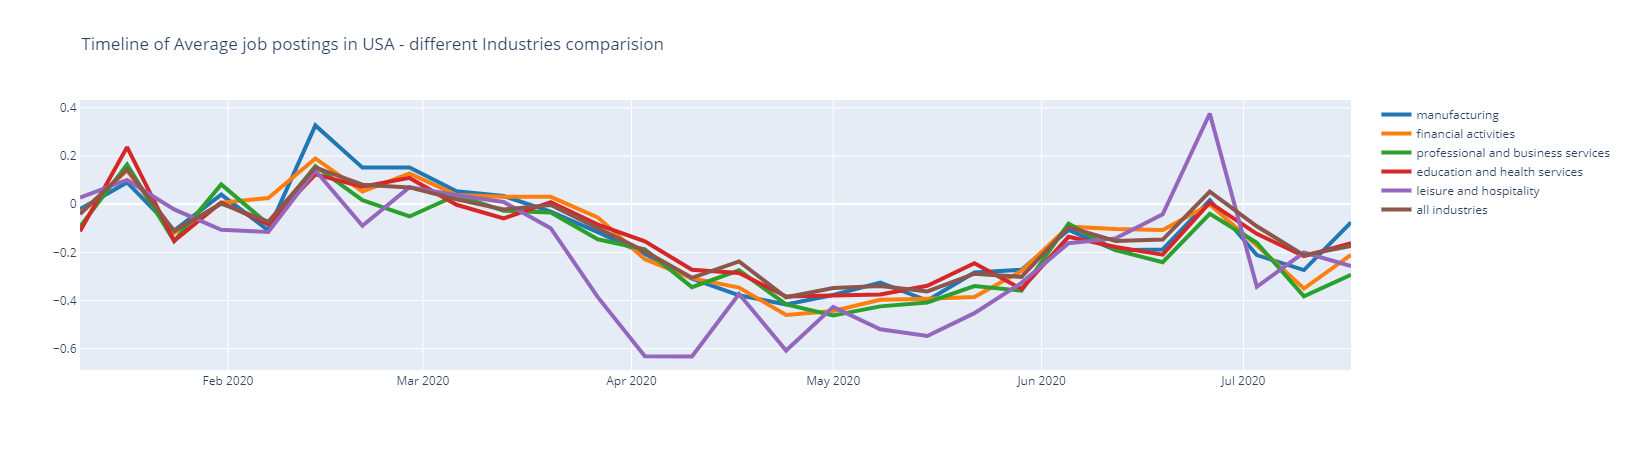

In [217]:
data = df_burnings_date
fig = go.Figure()
cols = plotly.colors.DEFAULT_PLOTLY_COLORS

# Create and style traces
fig.add_trace(go.Scatter(x=data['date'], y=data['manufacturing'], name='manufacturing',showlegend=True,
                         line=dict(color=cols[0], width=4)))

fig.add_trace(go.Scatter(x=data['date'], y=data['financial activities'], name='financial activities',showlegend=True,
                         line=dict(color=cols[1], width=4)))

fig.add_trace(go.Scatter(x=data['date'], y=data['professional and business services'], name='professional and business services',showlegend=True,
                         line=dict(color=cols[2], width=4)))

fig.add_trace(go.Scatter(x=data['date'], y=data['education and health services'], name='education and health services',showlegend=True,
                         line=dict(color=cols[3], width=4)))

fig.add_trace(go.Scatter(x=data['date'], y=data['leisure and hospitality'], name='leisure and hospitality',showlegend=True,
                         line=dict(color=cols[4], width=4)))

fig.add_trace(go.Scatter(x=data['date'], y=data['all industries'], name='all industries',showlegend=True,
                         line=dict(color=cols[5], width=4)))
fig.update_layout(title='Timeline of Average job postings in USA - different Industries comparision')

fig.show()

## box plot - comparison of average job postings value between different industries

The high variance in values of average job postings leisure and hospitality is also seen in the box plot below.

Whereas Education and health services are fairly stable during the pandemic. 

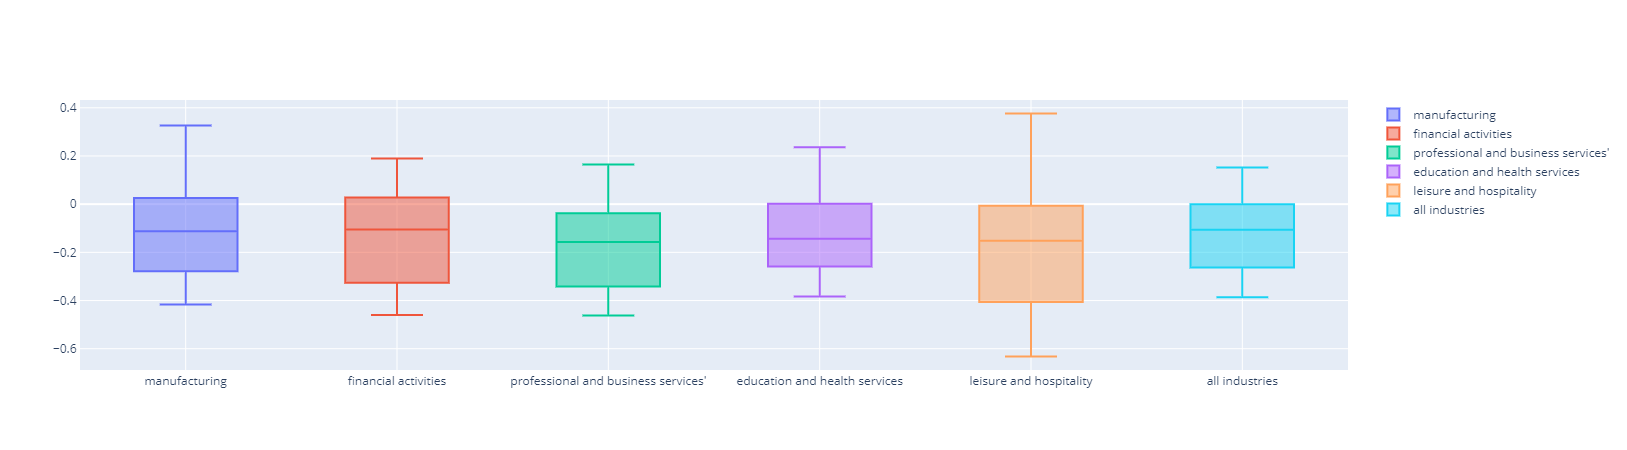

In [218]:
df = df_burnings_date
trace0 = go.Box(y=df["manufacturing"],name="manufacturing")
trace1 = go.Box(y=df["financial activities"],name="financial activities")
trace2 = go.Box(y=df["professional and business services"],name="professional and business services'")
trace3 = go.Box(y=df["education and health services"],name="education and health services")
trace4 = go.Box(y=df["leisure and hospitality"],name="leisure and hospitality")
trace5 = go.Box(y=df["all industries"],name="all industries")
data = [trace0, trace1,trace2,trace3,trace4,trace5]

iplot(data)

## Timeline of average job posting for All Industries, by different states

We will also color it with different regions, to analyze if there is any pattern.

It is not easy to make sense of the subplots below but we can see some patterns, things to note - 

- Most of the states follow a similar pattern od drop during April, May, and surge in June, July.
- postings in Hawaii hasn't yet recovered after the drop
- Most of the states have a point where the job postings are back to "peak" and then drop back again. 

    Some of the examples are - 
        - West Virginia, Maine  on April 17th
        - Washington on June 5
        - Vermont, Florida, Indiana, Arizona on June 26th

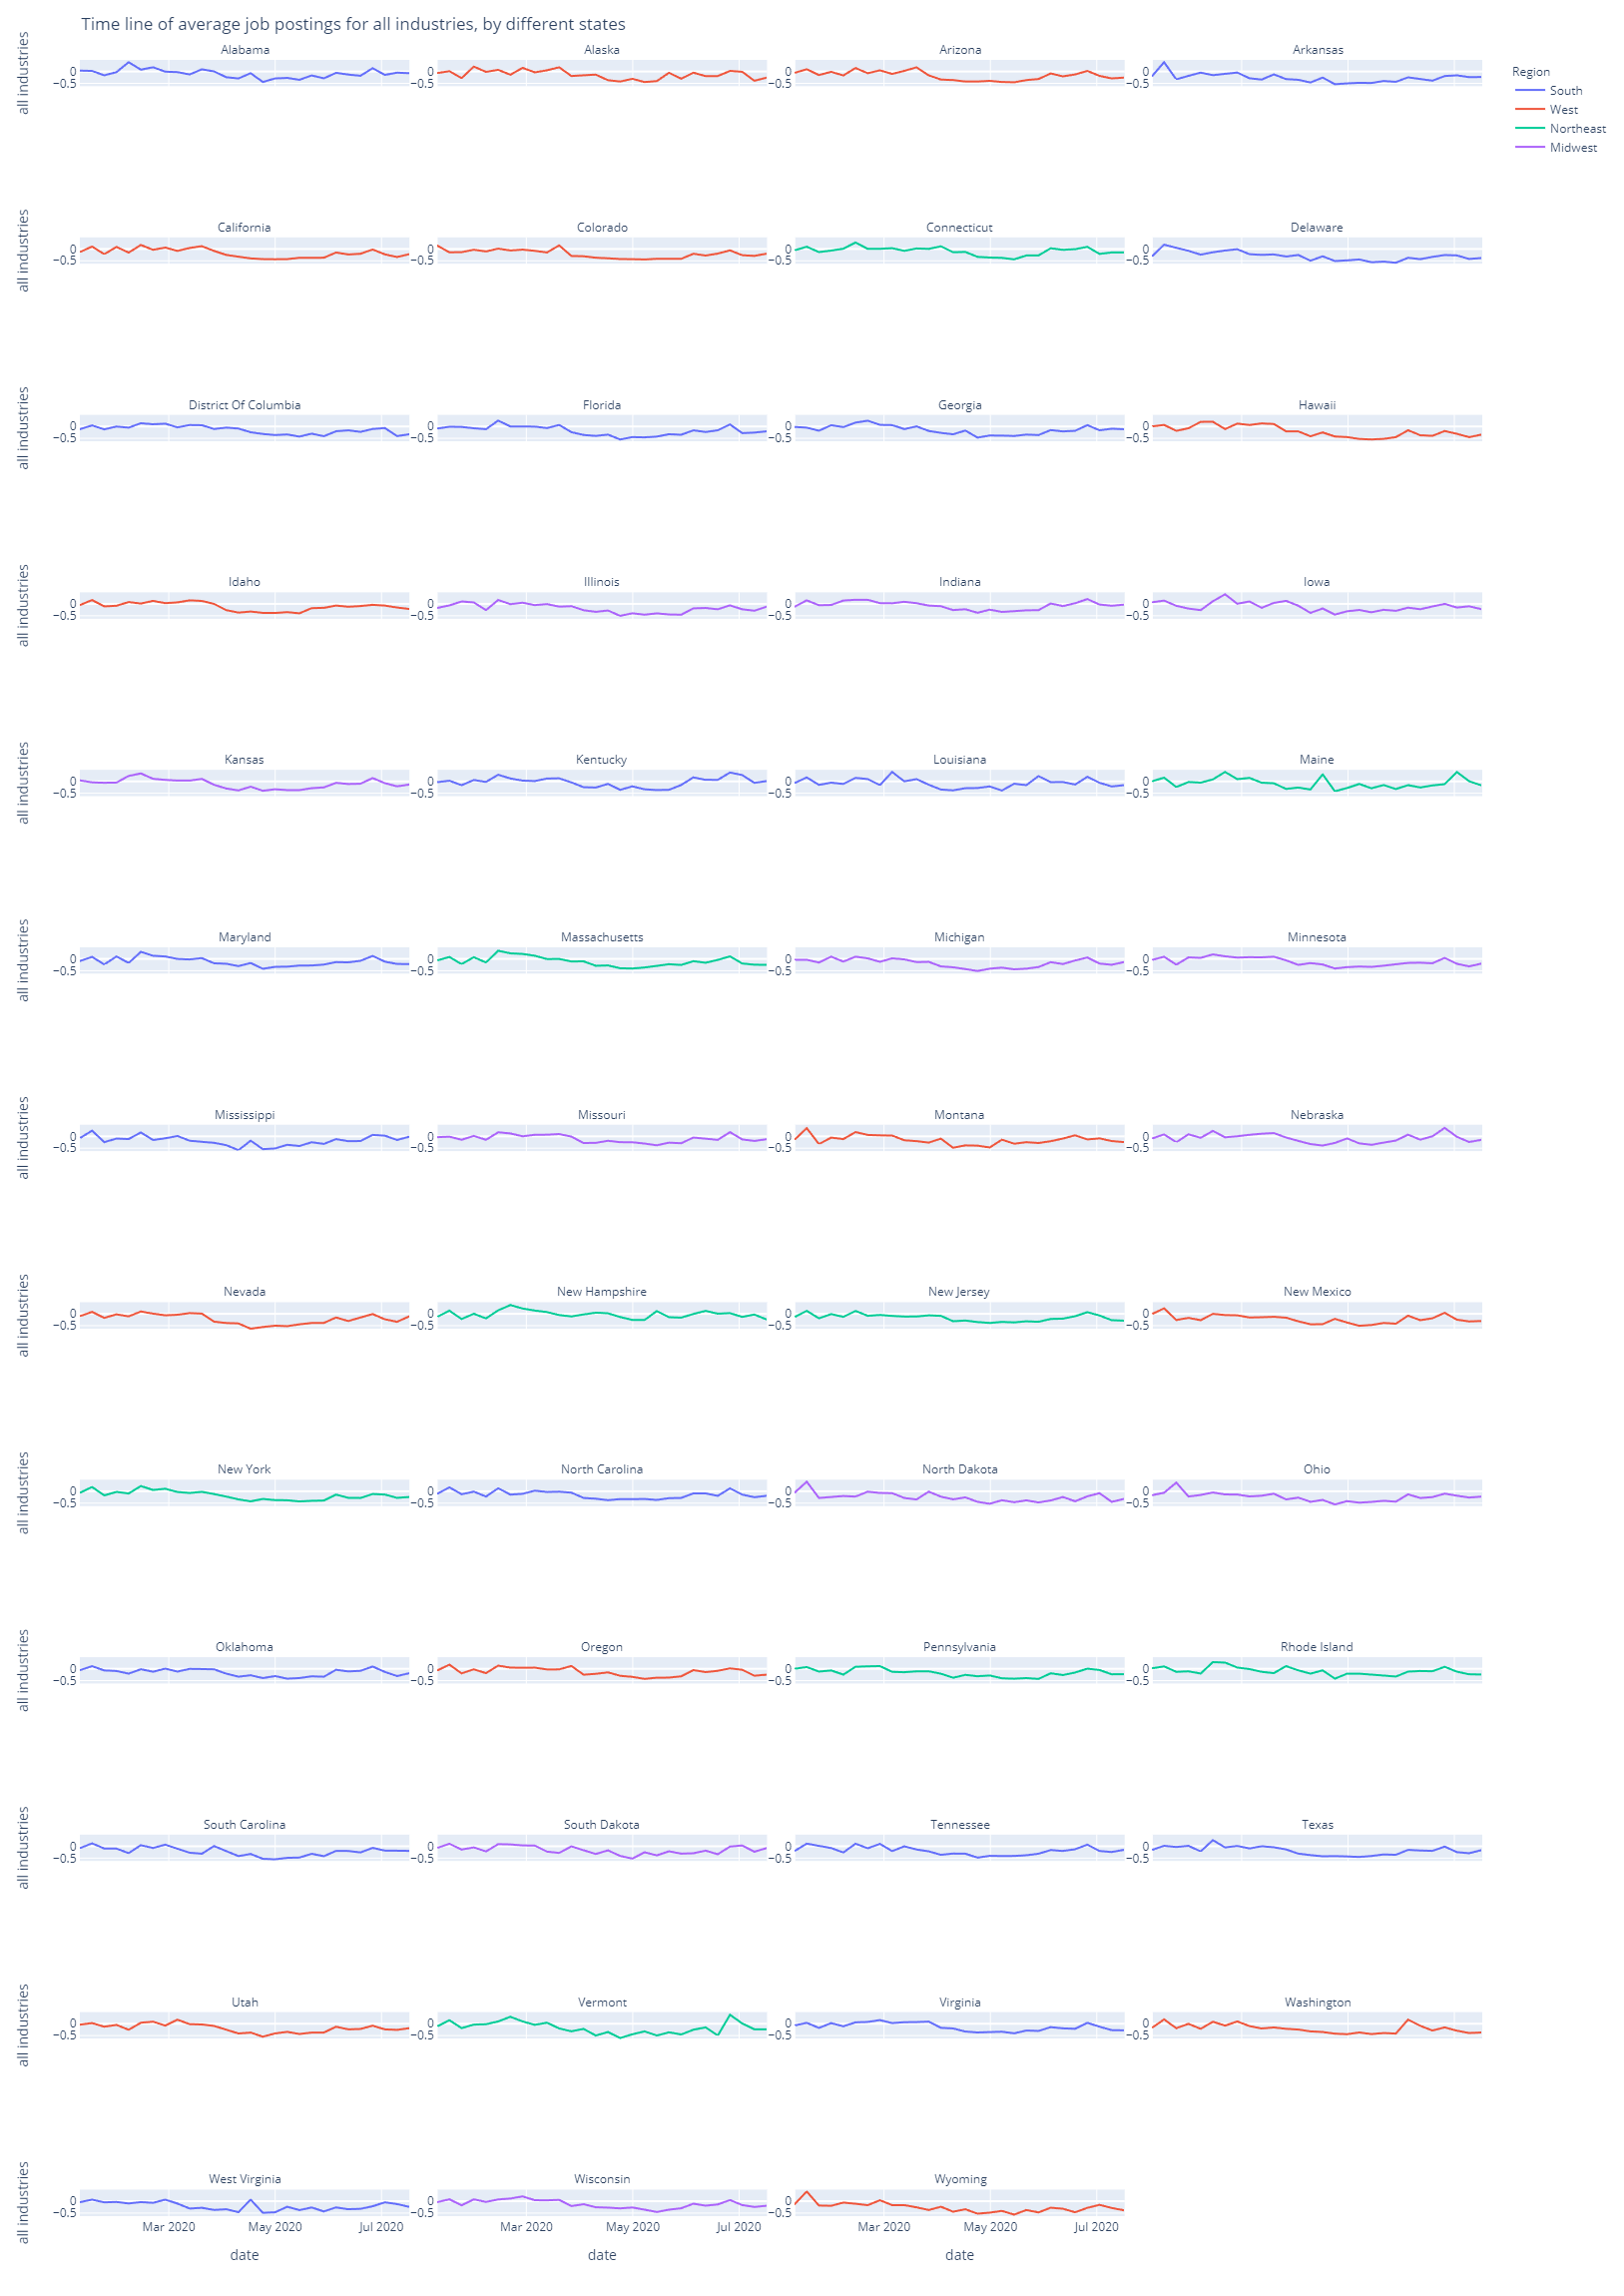

In [219]:
#color_continuous_scale=px.colors.sequential.YlOrRd,
data = df_burnings_date_state
fig = px.line(data, x="date", y="all industries",facet_col='statename', color="Region",facet_col_wrap=4,height=2300)
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_yaxes(showticklabels=True)
fig.update_layout(title="Time line of average job postings for all industries, by different states")
fig.show()

# Correlation - population vs average job postings
- The population doesn't seem to affect average job postings by industries


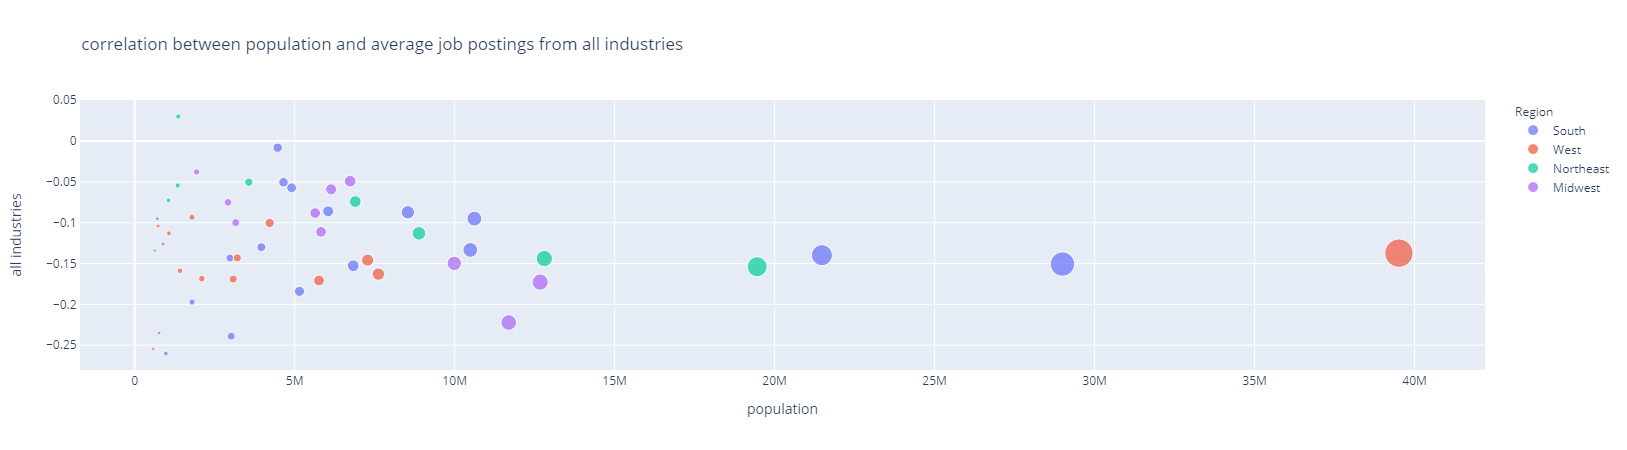

In [220]:
fig = px.scatter(df_burnings_state,y="all industries",x="population",color="Region",hover_data=["statename"],size="population",title="correlation between population and average job postings from all industries")
fig.show()

## Average job postings - by different industries, States 

Let us take a look at States which have thrived in different Industries, despite COVID-19, meaning they have a positive average job posting (compared to its own value in Jan)
- All industries - New Hampshire
- Manufacturing - Maine, Vermont
- Financial activities - Mississippi
- Professional and Business - Alabama, Alaska
- Education and health - Connecticut
- Leisure and hospitality - None of the states could manage a positive value for this industry.

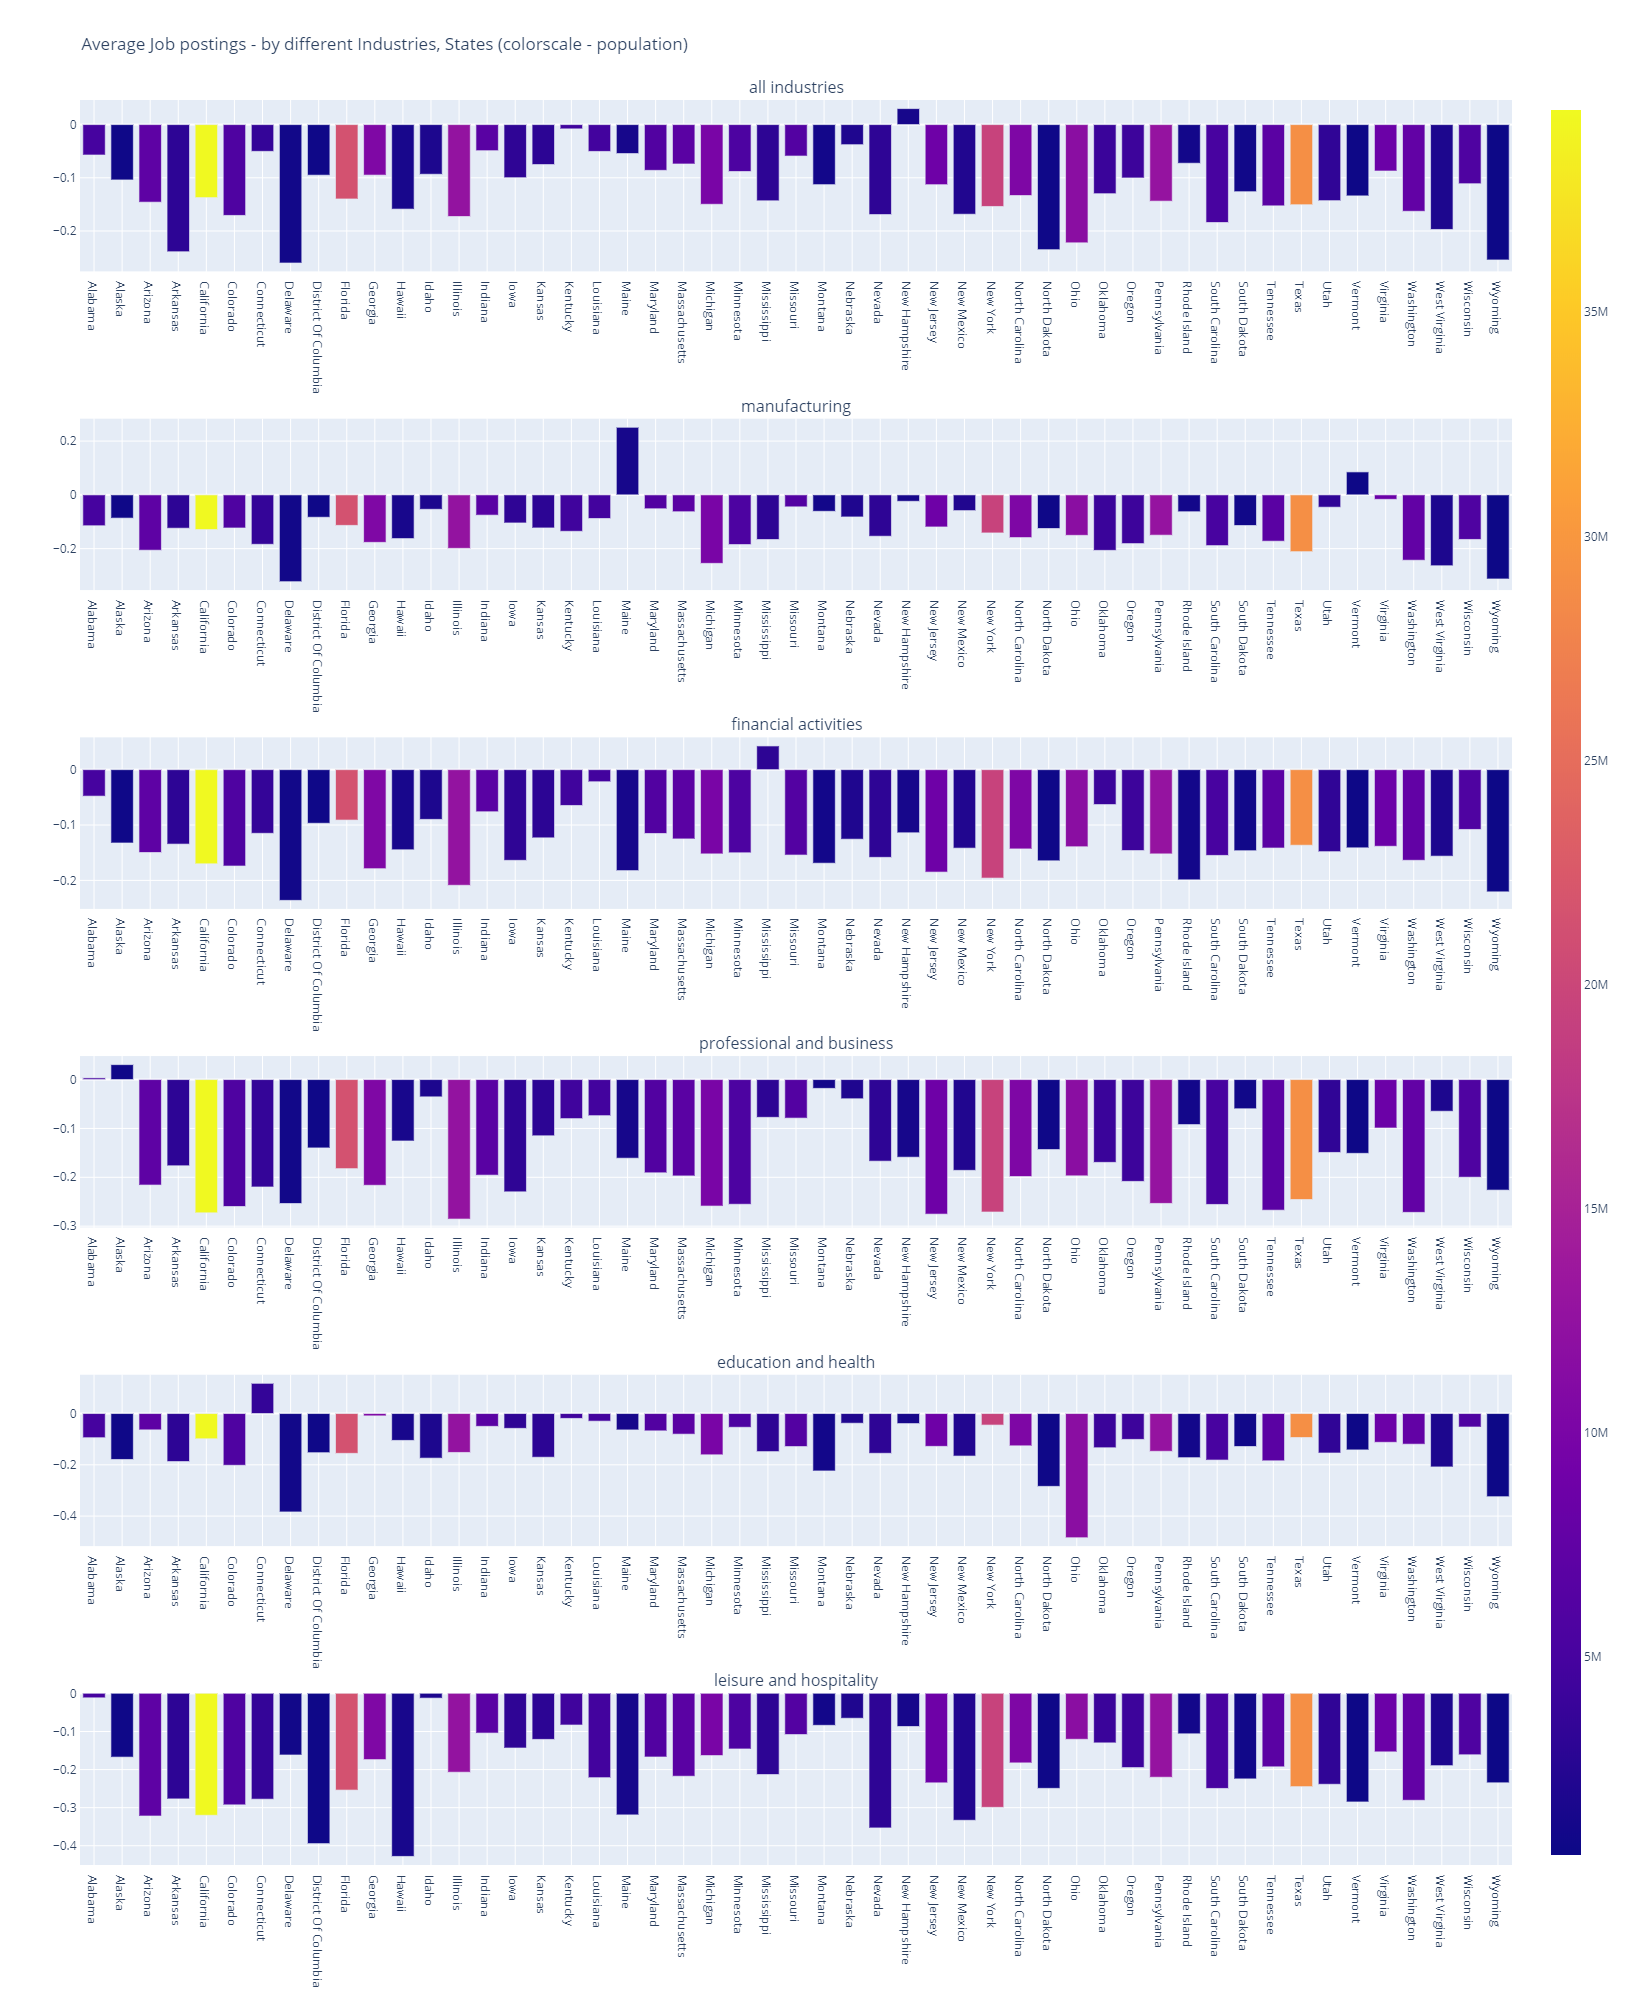

In [221]:
data = df_burnings_state
fig = make_subplots(rows=6, cols=1,subplot_titles=('all industries','manufacturing','financial activities','professional and business','education and health','leisure and hospitality'))
fig.add_trace(go.Bar(x=data['statename'],y=data['all industries'],marker=dict(color=data['population'],coloraxis="coloraxis")),1,1)
fig.add_trace(go.Bar(x=data['statename'],y=data['manufacturing'],marker=dict(color=data['population'],coloraxis="coloraxis")),2,1)
fig.add_trace(go.Bar(x=data['statename'],y=data['financial activities'],marker=dict(color=data['population'],coloraxis="coloraxis")),3,1)
fig.add_trace(go.Bar(x=data['statename'],y=data['professional and business services'],marker=dict(color=data['population'],coloraxis="coloraxis")),4,1)
fig.add_trace(go.Bar(x=data['statename'],y=data['education and health services'],marker=dict(color=data['population'],coloraxis="coloraxis")),5,1)
fig.add_trace(go.Bar(x=data['statename'],y=data['leisure and hospitality'],marker=dict(color=data['population'],coloraxis="coloraxis")),6,1)
fig.update_layout(height=2000,title="Average Job postings - by different Industries, States (colorscale - population)",showlegend=False,legend_title_text='Population')
fig.show()

## Conclusion - 

As talked about in part 1, When we take Hawaii into consideration, we noticed that Unemployment insurance claims per COVID cases were too high. 
- And if we take a look at job postings for the leisure and hospitality industry for Hawaii it falls below -0.4 compared to Jan. 
- And we do know that Hawaii has a heavy reliance on the tourism industry. According to [this article](https://www.theguardian.com/us-news/2020/jul/26/hawaii-coronavirus-tourism-economy-impact) by the guardian, Hawaii despite having avoided a COVID spike has its tourist economy shattered.
- **This tells us how COVID has an impact on the economy, leading to a decline in job postings, and an increase in unemployment insurance claims in these regions**
- Leisure and hospitality industry have the highest variance in the average job posting values, going extremely low in April, May, and back high again in June, July. This could be a direct effect of lockdown.
- Whereas, Education and health industry have been stable. This could be due to online learning, and also more health staff required during COVID-19.